<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction
# Notebook 3 - Exploratory Data Analysis for Merged Dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# import datasets
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather_cleaned.csv')
spray = pd.read_csv('../assets/spray_cleaned.csv')

# Merge and clean datasets

In [3]:
# convert date type from object to datetime
train['Date'] =  pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
weather['date'] = pd.to_datetime(weather['date'])

In [4]:
# merge weather with train and test dataset respectively
train_merged = train.merge(weather, how = 'left', left_on = ['Date'], right_on = ['date'])
test_merged = test.merge(weather, how = 'left', left_on = ['Date'], right_on = ['date'])

In [5]:
# drop date column as it's duplicated
train_merged.drop(columns = ['date'], inplace = True)
test_merged.drop(columns = ['date'], inplace = True)

In [6]:
# breakdown date into year & month
train_merged['year'] = train_merged['Date'].dt.year
train_merged['month'] = train_merged['Date'].dt.month

test_merged['year'] = test_merged['Date'].dt.year
test_merged['month'] = test_merged['Date'].dt.month

In [7]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  tavg                    10506 non-null  float6

In [8]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  tavg                    116293 non-null  float64       
 12  heat                    116293

In [9]:
# convert all feature names to lowercase
train_merged.columns = train_merged.columns.str.lower()
test_merged.columns = test_merged.columns.str.lower()

In [10]:
# drop unnecessary columns
train_merged.drop(columns = ['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace = True)
test_merged.drop(columns = ['id', 'address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace = True)

## EDA

In [11]:
def plots(col_name, x_label, y_label, title):
    
    wnv_0 = train_merged[train_merged['wnvpresent'] == 0].groupby(col_name).sum()['nummosquitos']
    wnv_0 = pd.DataFrame(wnv_0)
    wnv_0['wnvpresent'] = 0
    
    wnv_1 = train_merged[train_merged['wnvpresent'] == 1].groupby(col_name).sum()['nummosquitos']
    wnv_1 = pd.DataFrame(wnv_1)
    wnv_1['wnvpresent'] = 1
    
    wnv_0_1 = pd.concat([wnv_0, wnv_1])
    wnv_0_1.reset_index(inplace = True)
    wnv_0_1 = wnv_0_1.round(4)

    
    g = sns.catplot(data = wnv_0_1, kind = 'bar', x = col_name, y = 'nummosquitos', hue = 'wnvpresent', height=10, aspect=2, legend = False, ci = None)
    g.set_axis_labels(x_label, y_label, fontsize = 14)
    plt.xticks(rotation = 45)
    plt.title(title, fontsize = 18);
    plt.legend(title = 'WNV Present', loc='upper right')

    plt.show()

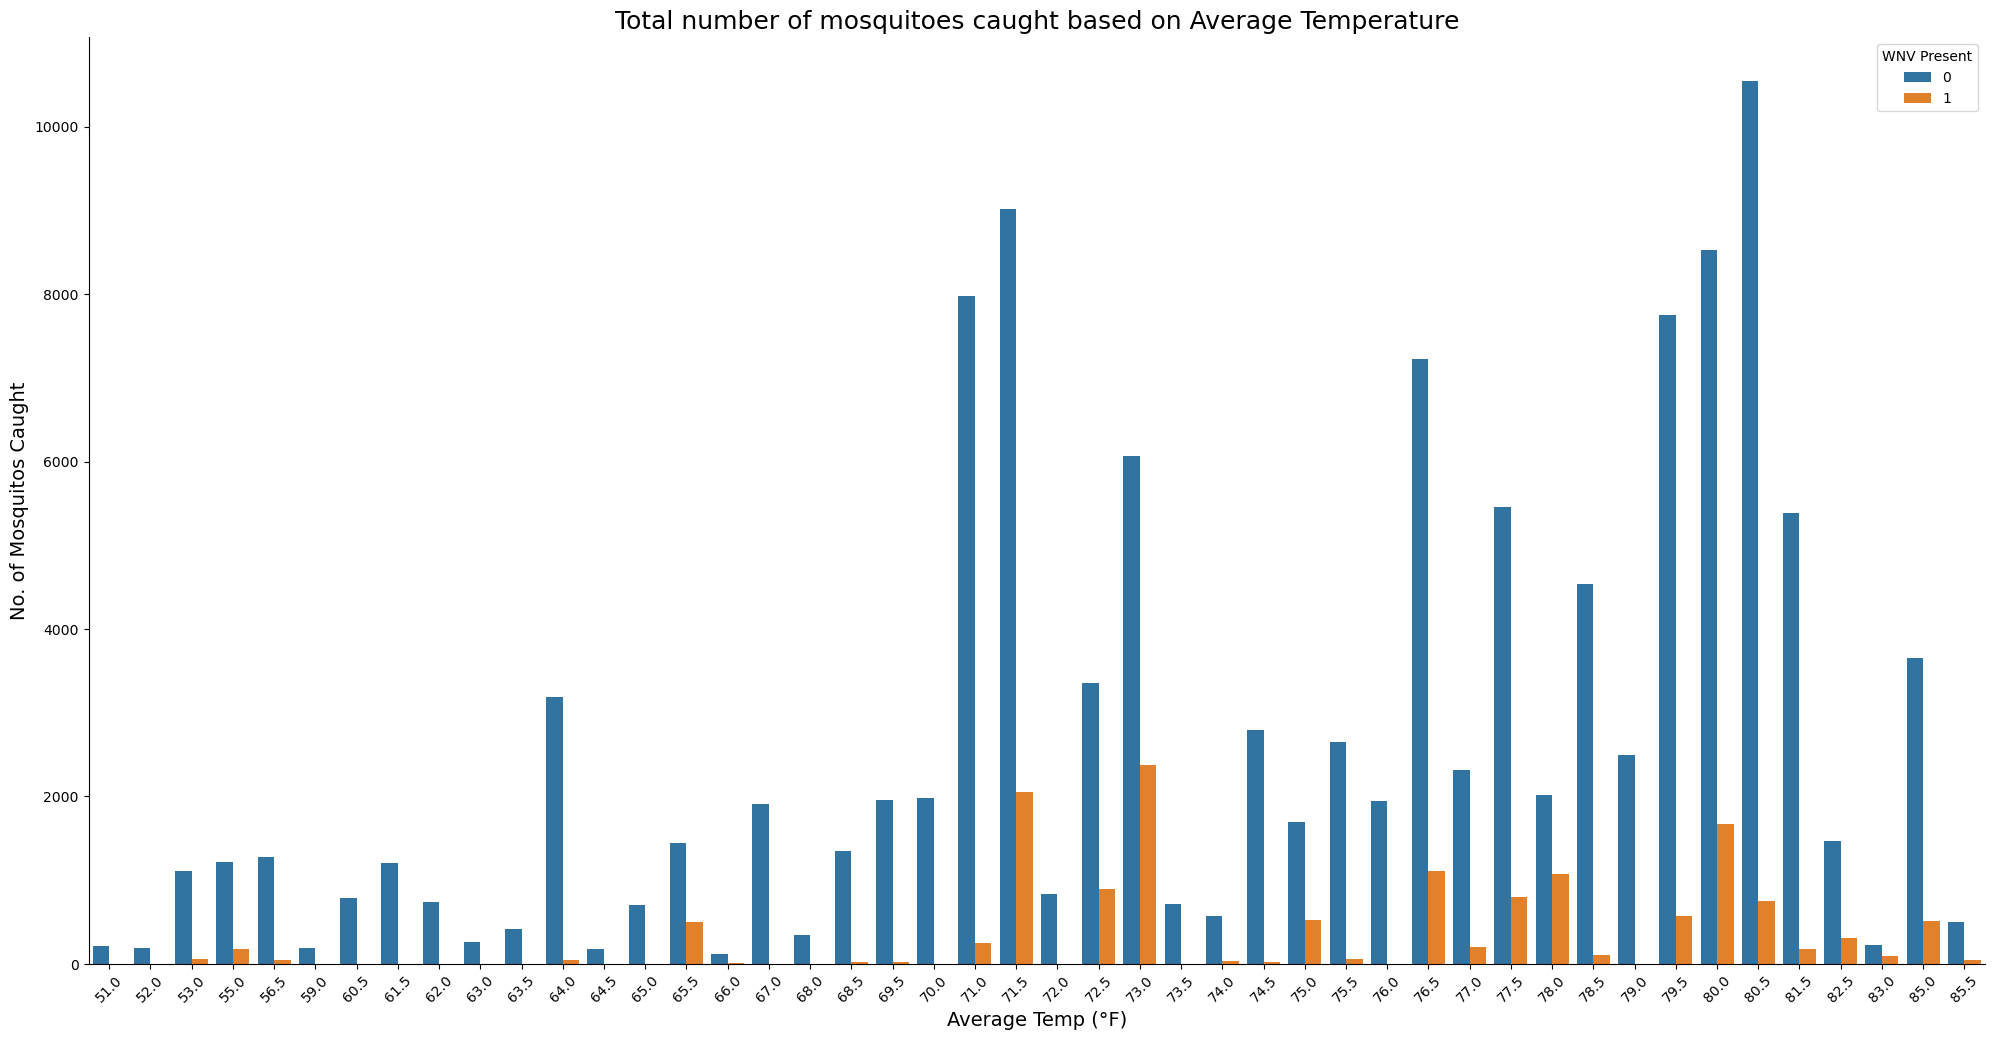

In [12]:
plots('tavg', 'Average Temp (°F)', 'No. of Mosquitos Caught', 'Total number of mosquitoes caught based on Average Temperature')

From the barplot above, we can observe that
1. More mosquitos are caught when the average temperature is between 71 and 81 degrees fahrenheit.
2. Most mosquitos caught do not have WNV virus.
3. The highest number of mosquitos with WNV were caught at an average temperature of 73 degrees. 

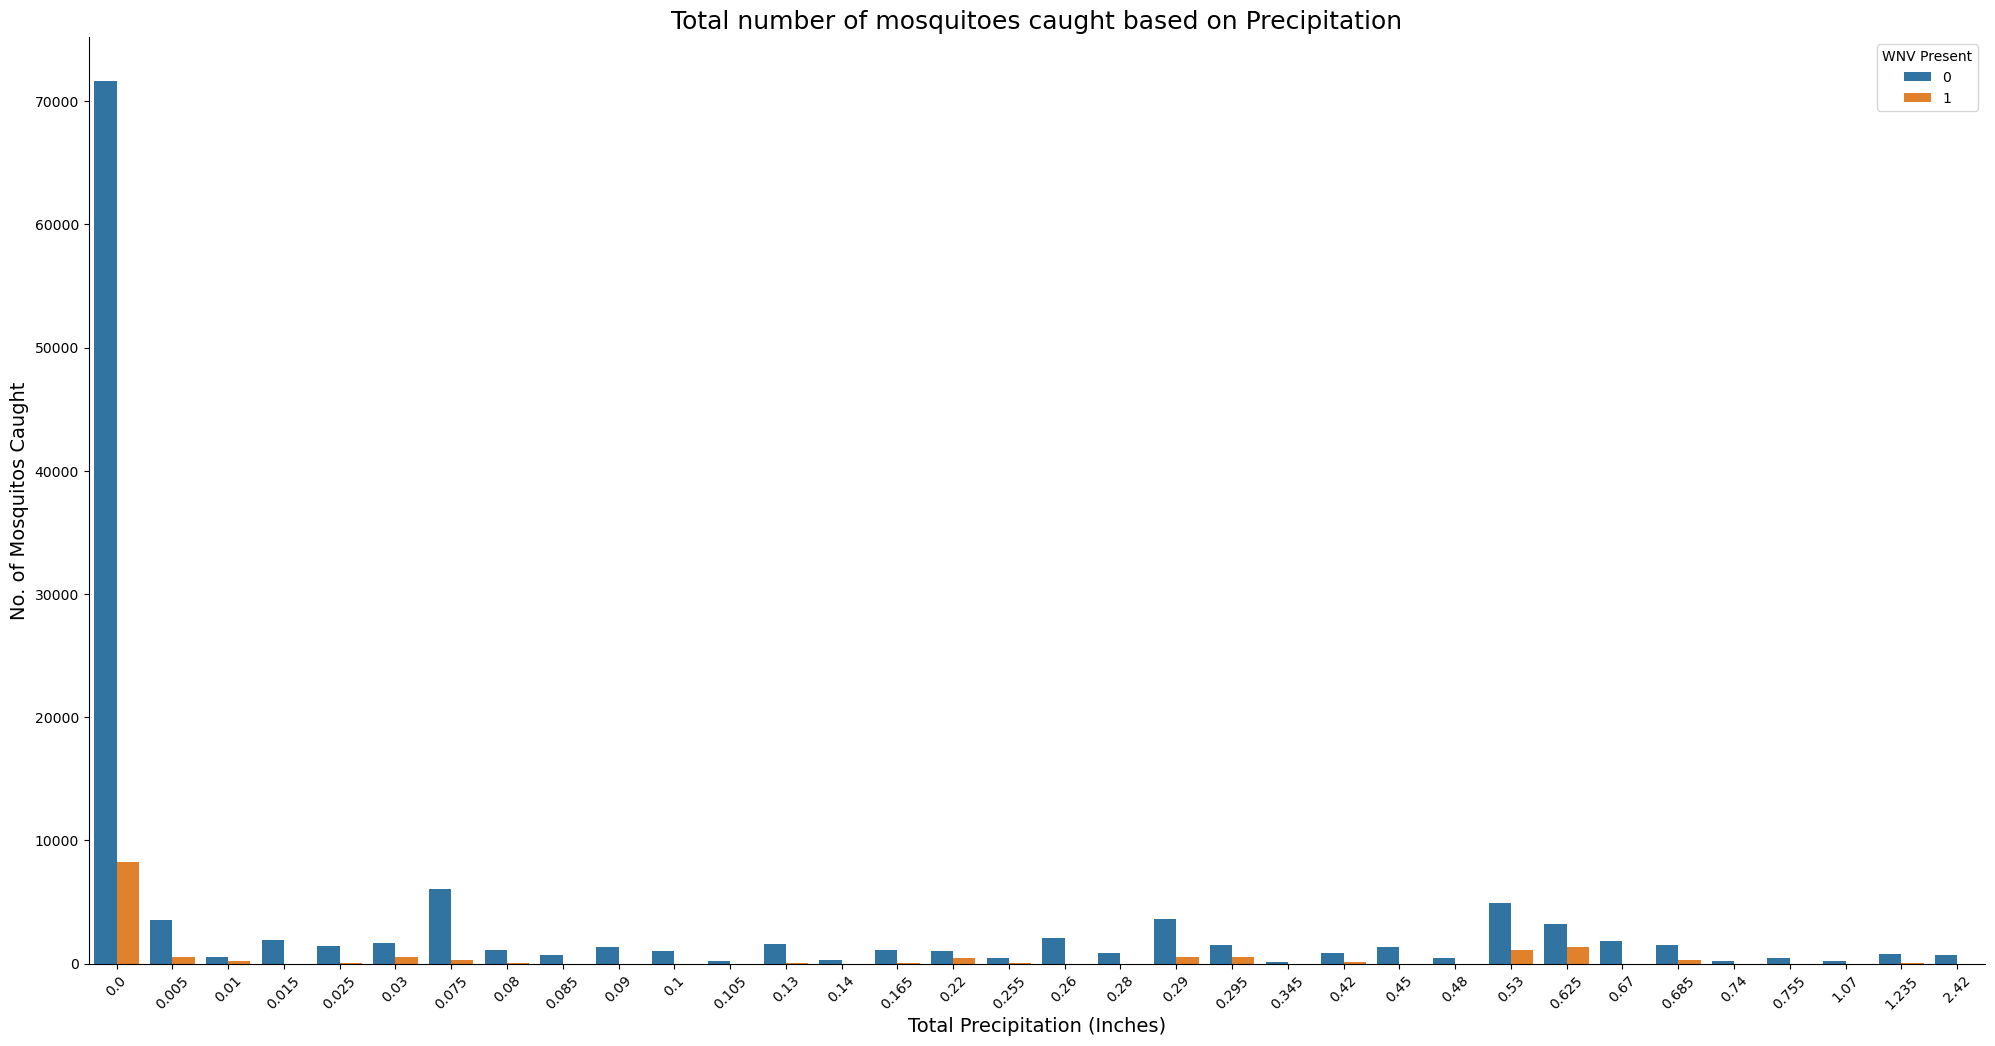

In [13]:
plots('precip_total', 'Total Precipitation (Inches)', 'No. of Mosquitos Caught', 'Total number of mosquitoes caught based on Precipitation')

From the barplot above, we can observe that mosquitoes are usually caught when precipitation is 0.
This is aligned with the understanding that mosquitoes do not like rain.

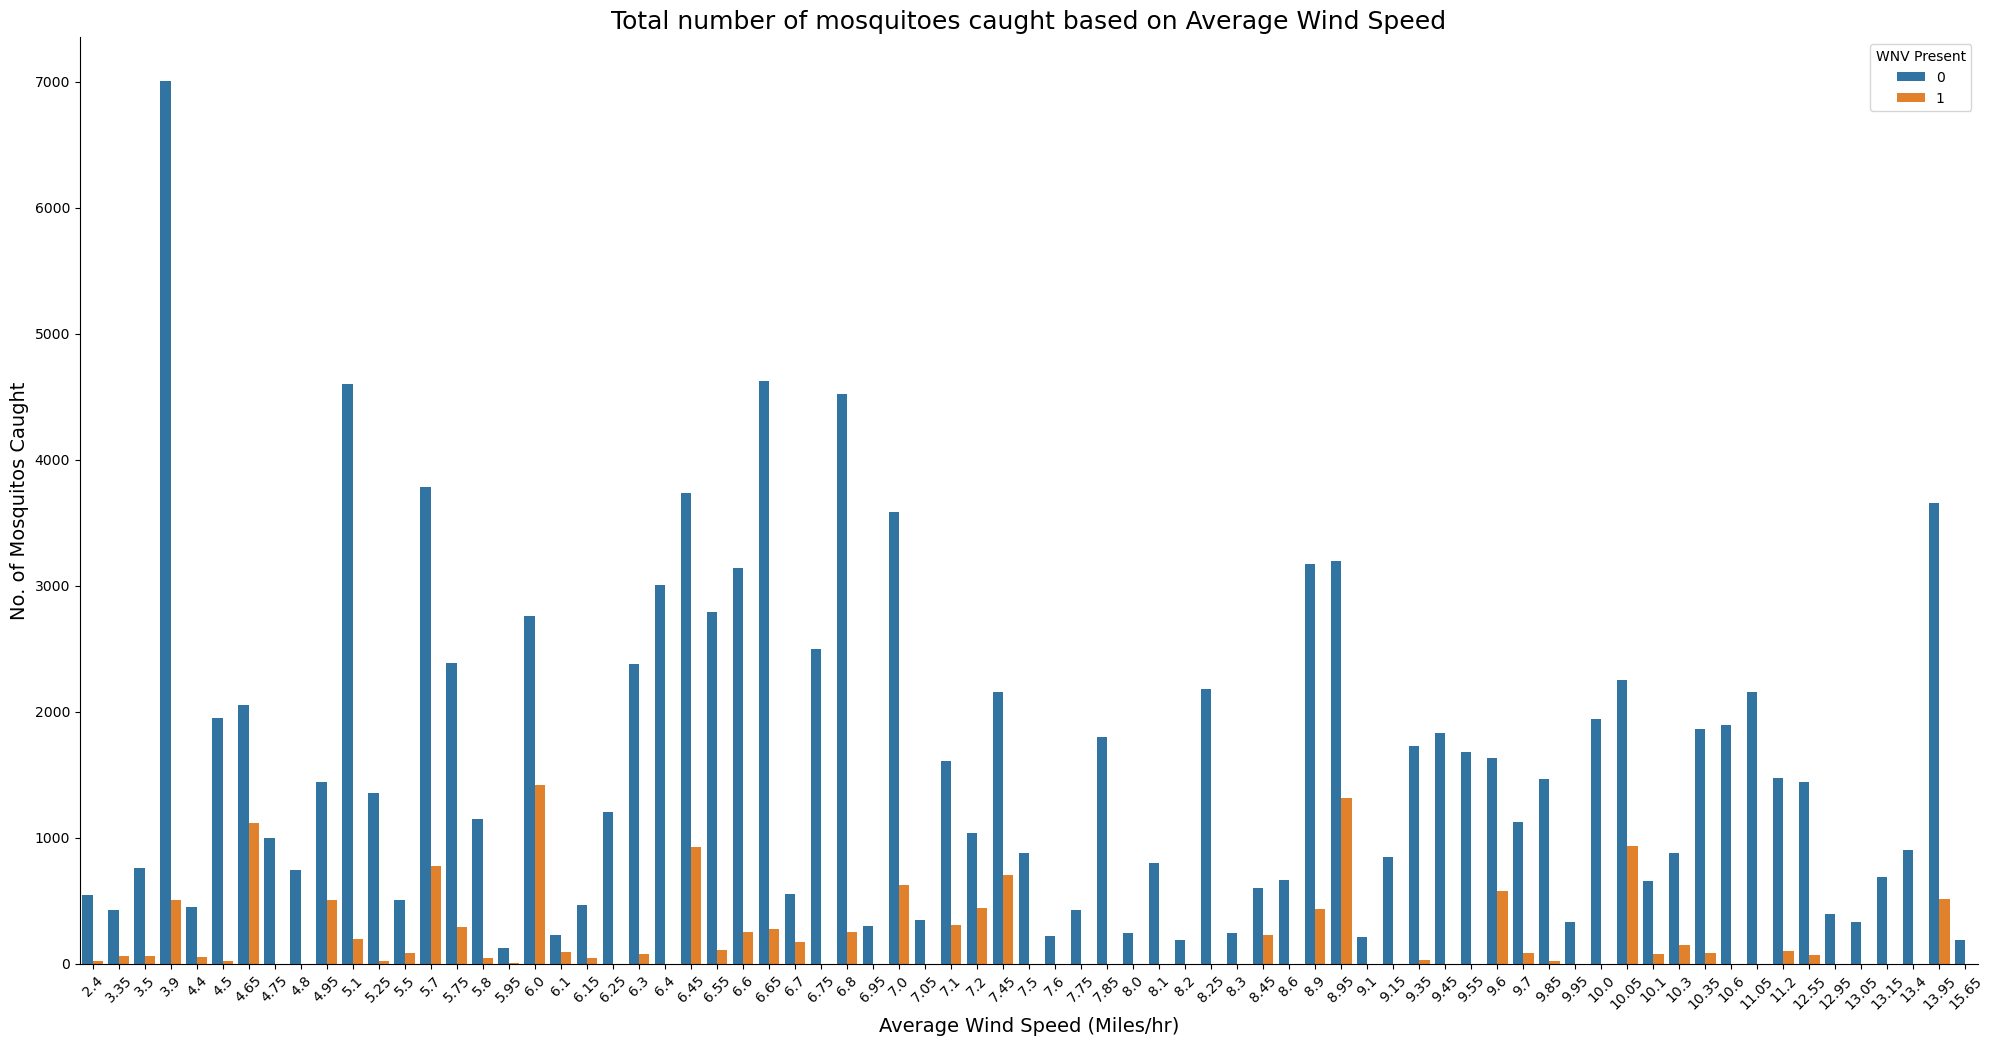

In [14]:
plots('avg_speed', 'Average Wind Speed (Miles/hr)', 'No. of Mosquitos Caught', 'Total number of mosquitoes caught based on Average Wind Speed')

The barplot above shows the relationship between average wind speed and the total number of mosquitos caught across the years in the train dataset. 
As average wind speed increase, there is a general decrease in the number of mosquitos caught. This further supports studies that show that mosquitos do not fly well at high wind speeds. Higher wind speeds may also affect the number of mosquitos caught as it dilutes the attractants of the traps. 

# Preprocessing

## One Hot Encoding On Species of Mosquitos

In [15]:
# one hot encoding
df_train = pd.get_dummies(train_merged, columns = ['species'], prefix = '', prefix_sep = '')
df_test = pd.get_dummies(test_merged, columns = ['species'], prefix = '', prefix_sep = '')

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    116293 non-null  datetime64[ns]
 1   trap                    116293 non-null  object        
 2   latitude                116293 non-null  float64       
 3   longitude               116293 non-null  float64       
 4   tavg                    116293 non-null  float64       
 5   heat                    116293 non-null  float64       
 6   precip_total            116293 non-null  float64       
 7   result_dir              116293 non-null  float64       
 8   avg_speed               116293 non-null  float64       
 9   daytime_min             116293 non-null  float64       
 10  temp_diff               116293 non-null  float64       
 11  year                    116293 non-null  int64         
 12  month                   116293

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   trap                    10506 non-null  object        
 2   latitude                10506 non-null  float64       
 3   longitude               10506 non-null  float64       
 4   nummosquitos            10506 non-null  int64         
 5   wnvpresent              10506 non-null  int64         
 6   tavg                    10506 non-null  float64       
 7   heat                    10506 non-null  float64       
 8   precip_total            10506 non-null  float64       
 9   result_dir              10506 non-null  float64       
 10  avg_speed               10506 non-null  float64       
 11  daytime_min             10506 non-null  float64       
 12  temp_diff               10506 non-null  float6

In [18]:
df_train.head()

,date,trap,latitude,longitude,nummosquitos,wnvpresent,tavg,heat,precip_total,result_dir,...,temp_diff,year,month,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,2007-05-29,T002,41.954690,-87.800991,1,0,75.5,0.0,0.0,17.0,...,25.5,2007,5,0,0,1,0,0,0,0
1,2007-05-29,T002,41.954690,-87.800991,1,0,75.5,0.0,0.0,17.0,...,25.5,2007,5,0,0,0,1,0,0,0
2,2007-05-29,T007,41.994991,-87.769279,1,0,75.5,0.0,0.0,17.0,...,25.5,2007,5,0,0,0,1,0,0,0
3,2007-05-29,T015,41.974089,-87.824812,1,0,75.5,0.0,0.0,17.0,...,25.5,2007,5,0,0,1,0,0,0,0
4,2007-05-29,T015,41.974089,-87.824812,4,0,75.5,0.0,0.0,17.0,...,25.5,2007,5,0,0,0,1,0,0,0


# Feature Engineering

In [19]:
# extract latitude and longitutde 
train_coord = df_train[['latitude', 'longitude']]
test_coord = df_test[['latitude', 'longitude']]

In [20]:
# scale latitude and longitude
sc = StandardScaler()
X_sc = sc.fit_transform(train_coord)
X_test_sc = sc.transform(test_coord)

In [21]:
# instantiate kmeans
km_train = KMeans(n_clusters = 15, random_state = 42)
km_train.fit(X_sc)

km_test = KMeans(n_clusters = 15, random_state = 42)
km_test.fit(X_test_sc)

KMeans(n_clusters=15, random_state=42)

In [22]:
# tag clusters back to dataframe
df_train['trap_cluster'] = km_train.labels_
df_test['trap_cluster'] = km_test.labels_

In [23]:
df_train.head()

,date,trap,latitude,longitude,nummosquitos,wnvpresent,tavg,heat,precip_total,result_dir,...,year,month,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,trap_cluster
0,2007-05-29,T002,41.954690,-87.800991,1,0,75.5,0.0,0.0,17.0,...,2007,5,0,0,1,0,0,0,0,10
1,2007-05-29,T002,41.954690,-87.800991,1,0,75.5,0.0,0.0,17.0,...,2007,5,0,0,0,1,0,0,0,10
2,2007-05-29,T007,41.994991,-87.769279,1,0,75.5,0.0,0.0,17.0,...,2007,5,0,0,0,1,0,0,0,0
3,2007-05-29,T015,41.974089,-87.824812,1,0,75.5,0.0,0.0,17.0,...,2007,5,0,0,1,0,0,0,0,10
4,2007-05-29,T015,41.974089,-87.824812,4,0,75.5,0.0,0.0,17.0,...,2007,5,0,0,0,1,0,0,0,10


In [24]:
df_test.head()

,date,trap,latitude,longitude,tavg,heat,precip_total,result_dir,avg_speed,daytime_min,...,month,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,UNSPECIFIED CULEX,trap_cluster
0,2008-06-11,T002,41.95469,-87.800991,75.0,0.0,0.0,18.0,10.2,910.0,...,6,0,0,1,0,0,0,0,0,6
1,2008-06-11,T002,41.95469,-87.800991,75.0,0.0,0.0,18.0,10.2,910.0,...,6,0,0,0,1,0,0,0,0,6
2,2008-06-11,T002,41.95469,-87.800991,75.0,0.0,0.0,18.0,10.2,910.0,...,6,0,1,0,0,0,0,0,0,6
3,2008-06-11,T002,41.95469,-87.800991,75.0,0.0,0.0,18.0,10.2,910.0,...,6,0,0,0,0,1,0,0,0,6
4,2008-06-11,T002,41.95469,-87.800991,75.0,0.0,0.0,18.0,10.2,910.0,...,6,0,0,0,0,0,0,1,0,6


In [25]:
# drop unnecessary columns
df_train_cleaned = df_train.drop(columns = ['date', 'year', 'latitude', 'longitude', 'trap'])
df_test_cleaned = df_test.drop(columns = ['date', 'year', 'latitude', 'longitude', 'trap'])

In [26]:
# export cleaned datasets as csv files
df_train_cleaned.to_csv('../assets/train_merged_cleaned.csv', index = False)
df_test_cleaned.to_csv('../assets/test_merged_cleaned.csv', index = False)